In [1]:
# Path setup
import sys
import os
import importlib
import time
from IPython.display import clear_output

%matplotlib inline

sys.path.append(os.path.dirname(os.path.join(os.getcwd(), "../src")))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from src import constants, utils

In [4]:
VOC2007_IMAGE_DIR = "../data/VOC2007/images/"
VOC2007_LABEL_DIR = "../data/VOC2007/labels/"
VOC2012_IMAGE_DIR = "../data/VOC2012/images/"
VOC2012_LABEL_DIR = "../data/VOC2012/labels/"
VOC2007_TEST_IMAGE_DIR = "../data/VOC2007_test/images"
VOC2007_TEST_LABEL_DIR = "../data/VOC2007_test/labels"

TRAIN_VALID_SPLIT = 0.2

In [5]:
apply_labels_dir = np.vectorize(lambda label, labels_dir: os.path.join(labels_dir, label))
apply_images_dir = np.vectorize(lambda label, images_dir: os.path.join(images_dir, label.replace(".txt", ".jpg")))

In [6]:
voc2007_labels = [label for label in os.listdir(VOC2007_LABEL_DIR) if utils.isExtension(label, ".txt")]
voc2007_images = apply_images_dir(voc2007_labels, VOC2007_IMAGE_DIR)
voc2007_labels = apply_labels_dir(voc2007_labels, VOC2007_LABEL_DIR)

print(voc2007_labels.shape, voc2007_images.shape)

(5011,) (5011,)


In [7]:
voc2012_labels = [label for label in os.listdir(VOC2012_LABEL_DIR) if utils.isExtension(label, ".txt")]
voc2012_images = apply_images_dir(voc2012_labels, VOC2012_IMAGE_DIR)
voc2012_labels = apply_labels_dir(voc2012_labels, VOC2012_LABEL_DIR)

print(voc2012_labels.shape, voc2012_images.shape)

(5717,) (5717,)


In [8]:
voc2007_test_labels = [label for label in os.listdir(VOC2007_TEST_LABEL_DIR) if utils.isExtension(label, ".txt")]
voc2007_test_images = apply_images_dir(voc2007_test_labels, VOC2007_TEST_IMAGE_DIR)
voc2007_test_labels = apply_labels_dir(voc2007_test_labels, VOC2007_TEST_LABEL_DIR)

print(voc2007_test_labels.shape, voc2007_test_images.shape)

(4952,) (4952,)


# EDA

In [9]:
GRID_SIZE = constants.GRID_SIZE
grid_step = 1 / GRID_SIZE

In [10]:
def read_labels_to_dataframe(labels):
    df = pd.DataFrame(columns = ["class", "x", "y", "w", "h", "file"])
    for idx, label in enumerate(labels):
        bbox_df = pd.read_csv(label, delim_whitespace=True, header=None, names=["class", "x", "y", "w", "h"])
        bbox_df["file"] = idx
        df = df.append(bbox_df)
        
    df["size"] = df["w"] * df["h"]
    df["ratio"] = df["w"] / df["h"]
    df["grid_x"] = df["x"] // grid_step
    df["grid_x"] = df["grid_x"].astype("int")
    df["grid_y"] = df["y"] // grid_step
    df["grid_y"] = df["grid_y"].astype("int")
    df["grid_idx"] = df["grid_x"] + GRID_SIZE * df["grid_y"]
    
    return df

In [11]:
voc2007_df = read_labels_to_dataframe(voc2007_labels)
voc2007_df.head()

,class,x,y,w,h,file,size,ratio,grid_x,grid_y,grid_idx
0,13,0.656156,0.558000,0.681682,0.468000,0,0.319027,1.456585,4,3,25
1,14,0.800300,0.389000,0.393393,0.538000,0,0.211646,0.731214,5,2,19
2,14,0.331832,0.466000,0.099099,0.076000,0,0.007532,1.303936,2,3,23
0,2,0.415000,0.498498,0.190000,0.180180,1,0.034234,1.054500,2,3,23
0,2,0.509000,0.446667,0.182000,0.194667,2,0.035429,0.934932,3,3,24


In [12]:
voc2012_df = read_labels_to_dataframe(voc2012_labels)
voc2012_df.head()

,class,x,y,w,h,file,size,ratio,grid_x,grid_y,grid_idx
0,14,0.433934,0.416000,0.723724,0.356000,0,0.257646,2.032932,3,2,17
0,11,0.708247,0.543000,0.579381,0.914000,1,0.529555,0.633897,4,3,25
1,11,0.334021,0.458000,0.663918,0.912000,1,0.605493,0.727980,2,3,23
0,14,0.337000,0.333333,0.266000,0.510511,2,0.135796,0.521047,2,2,16
0,13,0.511000,0.597598,0.074000,0.060060,3,0.004444,1.232100,3,4,31


In [13]:
voc2007_test_df = read_labels_to_dataframe(voc2007_test_labels)
voc2007_test_df.head()

,class,x,y,w,h,file,size,ratio,grid_x,grid_y,grid_idx
0,9,0.958,0.450667,0.084,0.106667,0,0.008960,0.787500,6,3,27
1,9,0.450,0.500000,0.060,0.136000,0,0.008160,0.441176,3,3,24
2,9,0.169,0.646667,0.162,0.141333,0,0.022896,1.146226,1,4,29
0,11,0.790,0.697333,0.080,0.114667,1,0.009173,0.697674,5,4,33
1,11,0.307,0.701333,0.138,0.149333,1,0.020608,0.924107,2,4,30


## Object class distribution

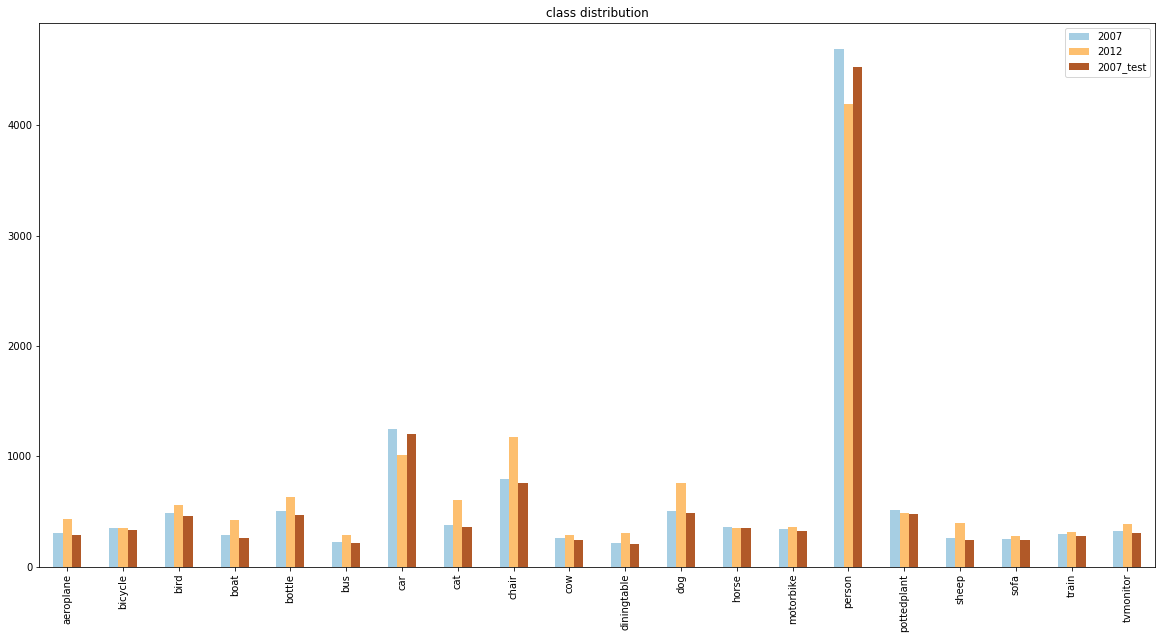

In [14]:
def plot_class_dist():
    class_df = pd.DataFrame()
    class_df["2007"] = voc2007_df[["class", "file"]].groupby("class").count()["file"]
    class_df["2012"] = voc2012_df[["class", "file"]].groupby("class").count()["file"]
    class_df["2007_test"] = voc2007_test_df[["class", "file"]].groupby("class").count()["file"]
    class_df.index = constants.CLASS_NAME
    
    class_df.plot.bar(figsize=(20, 10), colormap='Paired', title="class distribution")
    
plot_class_dist()

## Object location distribution

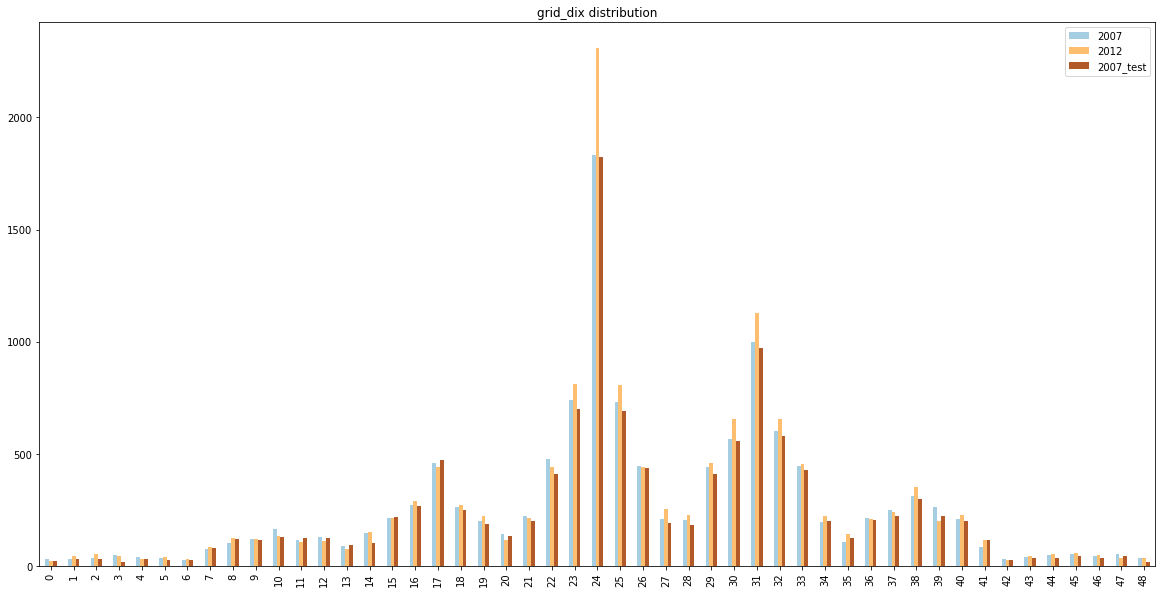

In [15]:
def plot_object_grid_index():
    
    idx_df = pd.DataFrame()
    idx_df["2007"] = voc2007_df[["grid_idx", "file"]].groupby("grid_idx").count()
    idx_df["2012"] = voc2012_df[["grid_idx", "file"]].groupby("grid_idx").count()
    idx_df["2007_test"] = voc2007_test_df[["grid_idx", "file"]].groupby("grid_idx").count()
    idx_df.index = np.arange(GRID_SIZE * GRID_SIZE)
    idx_df.fillna(0)

    idx_df.plot.bar(figsize=(20, 10), colormap='Paired', title="grid_dix distribution")
    
plot_object_grid_index()

## Numbers of objects in an image

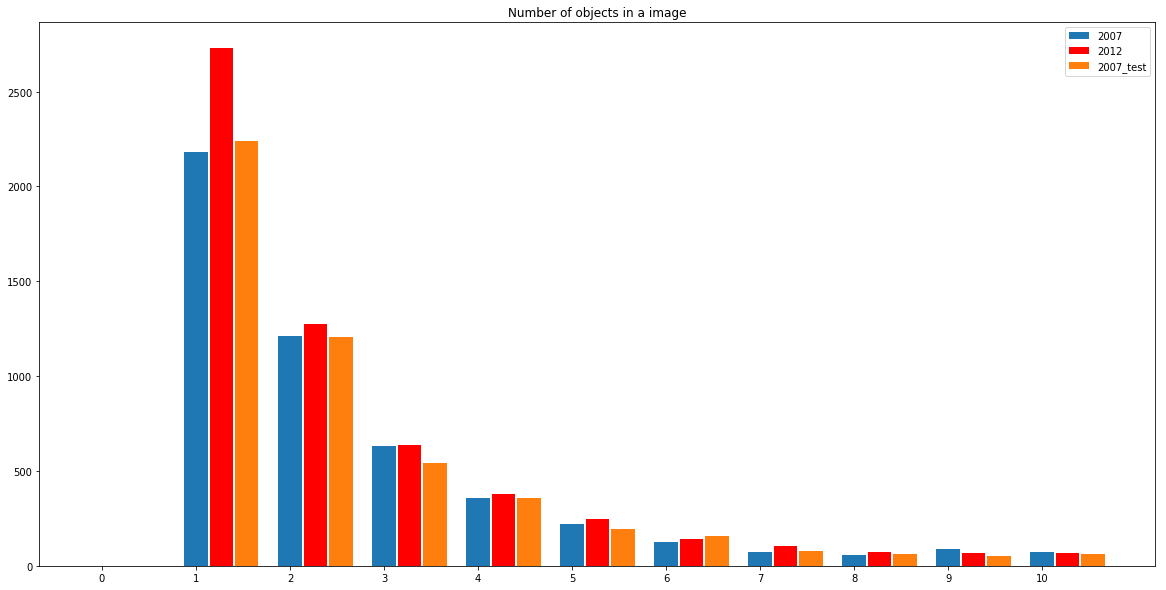

In [16]:
def plot_objects_in_image():
    
    MAX_NUM = 10
    
    num1 = voc2007_df[["class", "file"]].groupby("file").count()
    num2 = voc2012_df[["class", "file"]].groupby("file").count()
    num3 = voc2007_test_df[["class", "file"]].groupby("file").count()
    
    hist1, edge = np.histogram(num1, bins=MAX_NUM, range=(0, MAX_NUM))
    hist2, _ = np.histogram(num2, bins=MAX_NUM, range=(0, MAX_NUM))
    hist3, _ = np.histogram(num3, bins=MAX_NUM, range=(0, MAX_NUM))
    
    hist1 = np.append(hist1, num1[num1["class"] > MAX_NUM].count()[0])
    hist2 = np.append(hist2, num2[num2["class"] > MAX_NUM].count()[0])
    hist3 = np.append(hist3, num3[num3["class"] > MAX_NUM].count()[0])
    
    plt.figure(figsize=(20, 10))
    ax = plt.gca()

    ax.bar(edge + 0.00, hist1, width=0.25, label="2007")
    ax.bar(edge + 0.27, hist2, width=0.25, label="2012", color="red")
    ax.bar(edge + 0.54, hist3, width=0.25, label="2007_test")
    
    ax.set_xticks(edge)
    ax.legend()
    ax.set_title("Number of objects in a image")
    plt.show()
    
plot_objects_in_image()   

## Object size

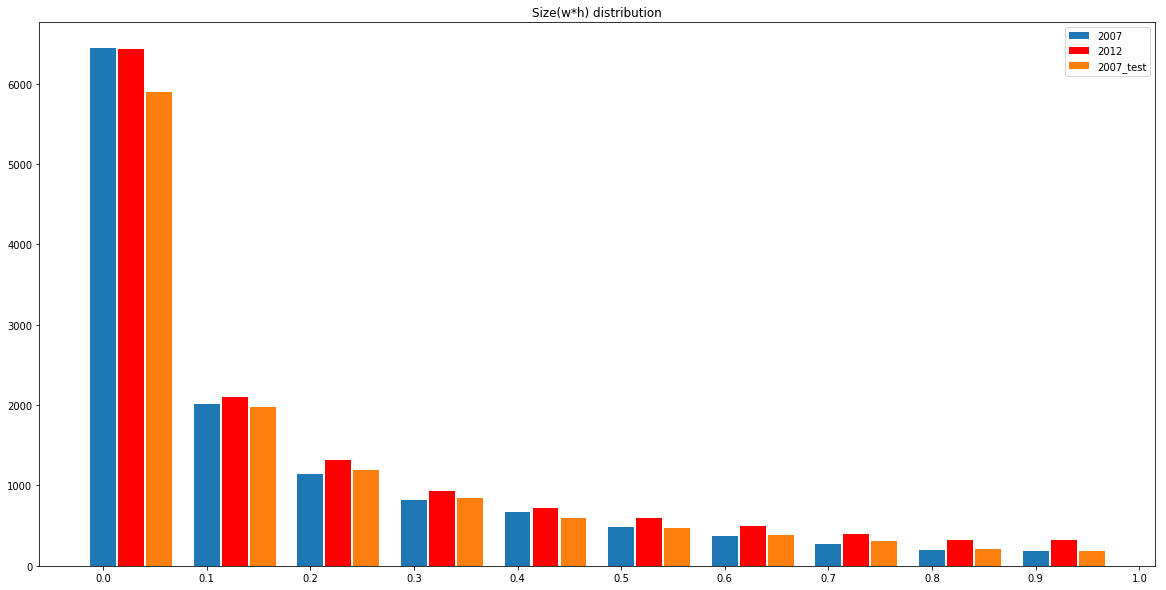

In [17]:
def plot_size_dist():
    hist1, edge = np.histogram(voc2007_df["size"], bins=10, range=(0, 1))
    hist2, _ = np.histogram(voc2012_df["size"], bins=10, range=(0, 1))
    hist3, _ = np.histogram(voc2007_test_df["size"], bins=10, range=(0, 1))
    
    plt.figure(figsize=(20, 10))
    ax = plt.gca()

    ax.bar(edge[:-1] + 0.000, hist1, width=0.025, label="2007")
    ax.bar(edge[:-1] + 0.027, hist2, width=0.025, label="2012", color="red")
    ax.bar(edge[:-1] + 0.054, hist3, width=0.025, label="2007_test")

    ax.set_xticks(edge)
    
    ax.legend()
    ax.set_title("Size(w*h) distribution")
    plt.show()

plot_size_dist()

## Bounding Box width, height ratio

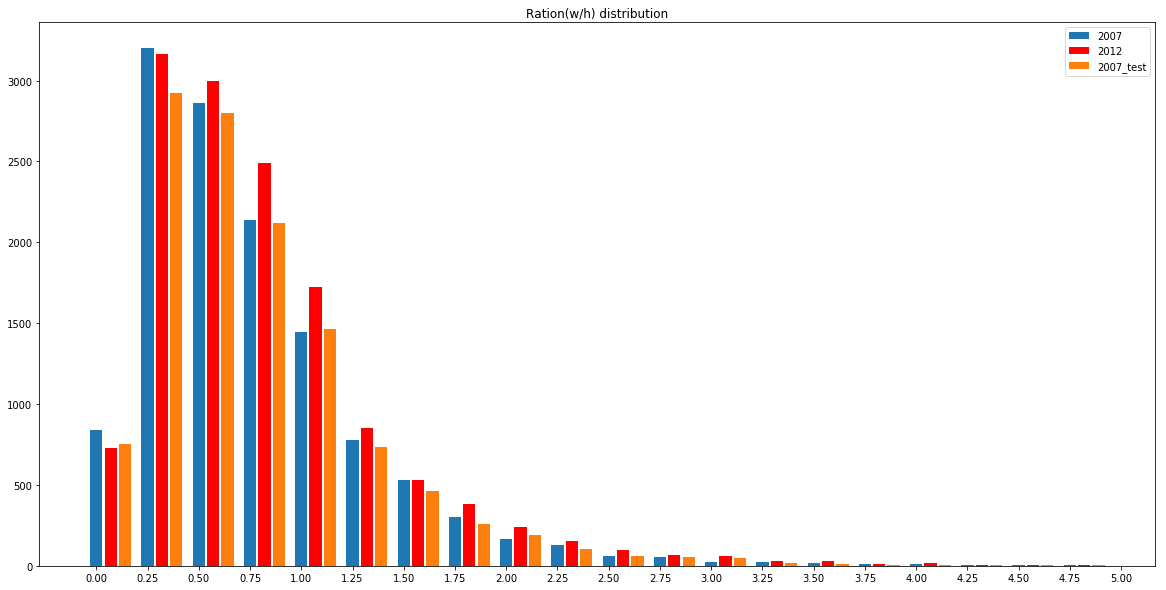

In [18]:
def plot_ratio_dist():
    hist1, edge = np.histogram(voc2007_df["ratio"], bins=20, range=(0, 5))
    hist2, _ = np.histogram(voc2012_df["ratio"], bins=20, range=(0, 5))
    hist3, _ = np.histogram(voc2007_test_df["ratio"], bins=20, range=(0, 5))
    
    plt.figure(figsize=(20, 10))
    ax = plt.gca()

    ax.bar(edge[:-1] + 0.00, hist1, width=0.06, label="2007")
    ax.bar(edge[:-1] + 0.07, hist2, width=0.06, label="2012", color="red")
    ax.bar(edge[:-1] + 0.14, hist3, width=0.06, label="2007_test")

    ax.set_xticks(edge)
    
    ax.legend()
    ax.set_title("Ration(w/h) distribution")
    plt.show()
    
plot_ratio_dist()

# Train, Valid split

In [19]:
all_images = np.concatenate([voc2007_images, voc2012_images, voc2007_test_images])
all_labels = np.concatenate([voc2007_labels, voc2012_labels, voc2007_test_labels])

print(all_images.shape, all_labels.shape)

(15680,) (15680,)


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=TRAIN_VALID_SPLIT, random_state=87)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(12544,) (12544,)
(3136,) (3136,)


In [22]:
def copy_file(source, dest_dir, extension):
    for i in range(len(source)):
        ori_name = source[i]
        file_name = "{}{:0>5d}{}".format(dest_dir, i, extension)
        
        %cp $ori_name $file_name

In [23]:
# copy_file(test_images, "../data/valid/images/", ".jpg")

In [24]:
# copy_file(test_labels, "../data/valid/labels/", ".txt")

In [25]:
# copy_file(train_images, "../data/train/images/", ".jpg")

In [26]:
# copy_file(train_labels, "../data/train/labels/", ".txt")